Построить модель прогнозирования продаж, которая учитывает день недели и акцию

Прогноз должен быть построен на январь 2024 года по всем товарам, которые участвовали в продажах в декабре 2023

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math 

Предобработка данных

In [2]:
sales = pd.read_csv('sales_raw.csv', sep=',')
discounts = pd.read_csv('discounts_raw.csv', sep=',')

In [3]:
# Преобразование даты в формат datetime
sales['date'] = pd.to_datetime(sales['date'])
discounts['date_start'] = pd.to_datetime(discounts['date_start'])
discounts['date_end'] = pd.to_datetime(discounts['date_end'])
sales['day_of_week'] = sales['date'].dt.dayofweek # столбец с днем недели (акция должна учитывать день недели)

# Объединим датасет с продажами и акциями
merged_data = pd.merge(discounts, sales,  on = 'item_id', how = 'left')

# Выберем только товары, которые продавались в декабре
sales_december = sales[(sales['date'] >= '2023-12-01') & (sales['date'] <= '2023-12-31')]
sales_december_items = sales_december['item_id'].unique()
data = merged_data[merged_data['item_id'].isin(sales_december_items)]

# Доавим столбец с разницей в цене до и после акции
data['price_dif'] = data['sale_price_before_promo'] - data['sale_price_time_promo']

C:\Users\User\AppData\Local\Temp\ipykernel_14048\440432471.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_dif'] = data['sale_price_before_promo'] - data['sale_price_time_promo']


In [4]:
# Посмотрим на пропущенные переменные
result = (
    data
    .isnull().sum()                  
    .sort_values(ascending = False)
)
result[result > 0]

# Пропуски данных только в promo_typeCode, заполним их нулями
data.fillna(0, inplace=True) 

C:\Users\User\AppData\Local\Temp\ipykernel_14048\238458090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


Построение модели

In [17]:
# Финальные даные для модели - оставим только item_id, promo_typeCode, date_start, qnty, day_of_week, price_dif
work_data = data.drop(['date_end', 'date', 'sale_price_before_promo', 'sale_price_time_promo'], axis = 1)

# Тест - данные с акциями после 1 января 2024
# Треин - данные с акциями до 1 января 2024

# X включает в себя: item_id, promo_typeCode, day_of_week, price_dif
X_train = work_data[(work_data['date_start'] < '2024-01-01')].drop(['date_start', 'qnty'], axis=1)
X_test = work_data[(work_data['date_start'] >= '2024-01-01')].drop(['date_start', 'qnty'], axis=1)

# Y включает в себя: qnty
y_train = work_data[(work_data['date_start'] < '2024-01-01')]['qnty']
y_test = work_data[(work_data['date_start'] >= '2024-01-01')]['qnty']


# Random Forest
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

# Предсказания
y_pred = regressor.predict(X_test)
pred = y_pred
actual = y_test

C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Оценка качества модели

In [18]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
oob_score = regressor.oob_score_
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}') 
print(f'Mean Squared Error: {mse}') 
print(f'Out-of-Bag Score: {oob_score}')
print(f'R-squared: {r2}') 

Root Mean Squared Error: 9.989364670354613
Mean Squared Error: 99.78740651732893
Out-of-Bag Score: 0.12117905081063363
R-squared: 0.14511411965335785


Предсказания на январь 2024

In [7]:
# Комбинации товаров (продаваемых в декабре 2023) и дат
january_dates = pd.date_range(start='2024-01-01', end='2024-01-31')
all_combinations = list(itertools.product(sales_december_items, january_dates))
january_data = pd.DataFrame(all_combinations, columns=['item_id', 'date'])

january_data['day_of_week'] = january_data['date'].dt.dayofweek
january_data['promo_typeCode'] = 0
january_data['price_dif'] = 0
january_predictions = regressor.predict(january_data[['item_id', 'day_of_week', 'promo_typeCode','price_dif']])

january_data['qnty'] = january_predictions #Сформировали датасет
january_data.to_csv('january_predictions.csv', sep=';', index=False)

C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Визуализируем для одного из товаров, продаваемых в декабре

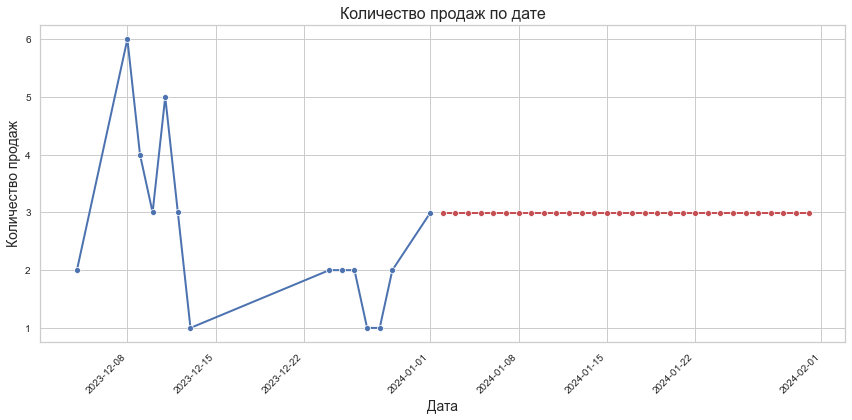

In [8]:
item_id = random.choice(sales_december_items)

dec = sales[(sales['item_id'] == item_id)]
jan = january_data[(january_data['item_id'] == item_id)]
combined_data  = pd.concat([dec[['date', 'qnty']], jan[['date', 'qnty']]], ignore_index=True)
combined_data = combined_data[(combined_data['date'] > '2023-12-01')]

before_2024 = combined_data[combined_data['date'] <= '2024-01-01']
after_2024 = combined_data[combined_data['date'] > '2024-01-01']

sns.set(style="whitegrid")
sns.set(style="whitegrid")

# Построение графика среднего значения продаж
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='qnty', data=before_2024, marker='o', color='b', linewidth=2)
sns.lineplot(x='date', y='qnty', data=after_2024, marker='o', color='r', linewidth=2)

plt.title('Количество продаж по дате', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()